# Treść zadania:
Tematem projektu będzie napisanie modelu filtru spamowego wykorzystując do tego celu dostępne przykładowe dane: https://www.kaggle.com/datasets/jerryanggara6/spam-filter-dataset.

Podstawowym założeniem jest korzystanie z modułów sparka do wczytywania, modyfikacji i manipulacji danymi. Filtr spamu trzeba zaimplementować za pomocą przetwarzania języka naturalnego zwanym analiza sentymentów. 

Proces tworzenia:
- oczysznienie danych i podzielenie na dwie klasy (spam i nie spam), tokenizacja danych,
- Stworzenie tzw. model worka słów czyli modyfikacja tekstu na numeryczny wektor cech,
- Zmniejszenie wagi mniej istotnym słowom,
- Przygotowanie modeli (przykładowo regresja logistyczna, naiwny klasyfikator Bayesa), 
- Podział na zbiór treningowy i testowy (kroswalidacja)
- Ocena jakości modelu 

Projekt zamiera możliwość przetestowania modelu (wpisanie własnego tekstu i sprawdzenie czy jest to spam czy nie).

In [ ]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=72973a54a0774f9f8f1ad7a845899d75b2c00fec0d19498d5ecb3adbde320b36
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Tokenizer, StopWordsRemover

import seaborn as sns
import matplotlib.pyplot as plt
import time


# Wczytanie danych

## Opis danych
Zbiór danych uzyty do badania filtru antyspamowego to kompleksowa kolekcja informacji, które służą do szkolenia algorytmów stosowanych w filtrach antyspamowych. W jego skład wchodzi zwykle szeroki zakres wiadomości e-mail, z których niektóre zostały oznaczone jako spam, a inne są legalnymi.


Podział danych na kategorie:
* 'ham': 87%
* 'spam1': 3%

Ilość unikalnych wartości: 5157


# Przygotowanie danych

## Tworzenie sesji

In [ ]:
spark = SparkSession.builder.appName('antyspam').getOrCreate()

## Wczytanie danych z pliku CSV

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/spam.csv"
df = spark.read.option("header", "true").csv(data_path)
df.show(10)

+--------+--------------------+
|Category|             Message|
+--------+--------------------+
|     ham|Go until jurong p...|
|     ham|Ok lar... Joking ...|
|    spam|Free entry in 2 a...|
|     ham|U dun say so earl...|
|     ham|Nah I don't think...|
|    spam|FreeMsg Hey there...|
|     ham|Even my brother i...|
|     ham|As per your reque...|
|    spam|WINNER!! As a val...|
|    spam|Had your mobile 1...|
+--------+--------------------+
only showing top 10 rows



## Oczyszczanie danych

In [ ]:
cleaned_df = df.select(col("Category").alias("label"), col("Message").alias("text"))

## Podział danych na dwie kategorię: spam i false-positive('ham')

In [ ]:
cleaned_df = cleaned_df.filter((col("label") == "spam") | (col("label") == "ham"))

## Tokenizacja tekstu

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
words_df = tokenizer.transform(cleaned_df)

## Usunięcie stop words

In [ ]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_words_df = remover.transform(words_df)

## Wyświetlenie przetworzonych danych

In [ ]:
filtered_words_df.show()

+-----+--------------------+--------------------+--------------------+
|label|                text|               words|      filtered_words|
+-----+--------------------+--------------------+--------------------+
|  ham|Go until jurong p...|[go, until, juron...|[go, jurong, poin...|
|  ham|Ok lar... Joking ...|[ok, lar..., joki...|[ok, lar..., joki...|
| spam|Free entry in 2 a...|[free, entry, in,...|[free, entry, 2, ...|
|  ham|U dun say so earl...|[u, dun, say, so,...|[u, dun, say, ear...|
|  ham|Nah I don't think...|[nah, i, don't, t...|[nah, think, goes...|
| spam|FreeMsg Hey there...|[freemsg, hey, th...|[freemsg, hey, da...|
|  ham|Even my brother i...|[even, my, brothe...|[even, brother, l...|
|  ham|As per your reque...|[as, per, your, r...|[per, request, 'm...|
| spam|WINNER!! As a val...|[winner!!, as, a,...|[winner!!, valued...|
| spam|Had your mobile 1...|[had, your, mobil...|[mobile, 11, mont...|
|  ham|I'm gonna be home...|[i'm, gonna, be, ...|[gonna, home, soo...|
| spam

# Budowa modelu worka

In [ ]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer

## Tworzenie modelu:

In [ ]:
cv = CountVectorizer(inputCol="filtered_words", outputCol="features")
cv_model = cv.fit(filtered_words_df)
vectorized_df = cv_model.transform(filtered_words_df)

## Podział danych na zbiór treningowy i testowy

In [ ]:
(train_data, test_data) = vectorized_df.randomSplit([0.8, 0.2], seed=42)

# Inicjalizacja modeli klasyfikacji

In [ ]:
lr = LogisticRegression(labelCol="label", featuresCol="features")
nb = NaiveBayes(labelCol="label", featuresCol="features")

## Trenowanie modeli

In [ ]:
indexer = StringIndexer(inputCol="label", outputCol="label_index")
indexed_train_data = indexer.fit(train_data).transform(train_data)

## Ocena wydajności modelu regresji logistycznej


In [ ]:
lr_predictions = lr_model.transform(indexed_train_data)
lr_predictionAndLabels = lr_predictions.select("prediction", "label_index").rdd
lr_metrics = MulticlassMetrics(lr_predictionAndLabels)
print("Logistic Regression Accuracy: {:.2f}".format(lr_metrics.accuracy))

Logistic Regression Accuracy: 1.00


## Trenowanie modelu naiwnego klasyfikatora Bayesa

In [ ]:
nb_model = nb.fit(indexed_train_data, {nb.labelCol: "label_index"})

## Ocena wydajności modelu naiwnego klasyfikatora Bayesa

In [ ]:
nb_predictions = nb_model.transform(indexed_train_data)
nb_predictionAndLabels = nb_predictions.select("prediction", "label_index").rdd
nb_metrics = MulticlassMetrics(nb_predictionAndLabels)
print("Naive Bayes Accuracy: {:.2f}".format(nb_metrics.accuracy))

Naive Bayes Accuracy: 1.00


In [ ]:
plt.imshow(lr_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'], rotation=45)
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Macierze pomyłek dla wybranych modeli regresji

## Tworzenie macierzy pomyłek dla modelu regresji logistycznej

In [ ]:
lr_predictionAndLabels = lr_predictions.select("prediction", "label_index").rdd
lr_metrics = MulticlassMetrics(lr_predictionAndLabels)

lr_confusion_matrix = lr_metrics.confusionMatrix().toArray()

## Wyświetlenie macierzy pomyłek dla modelu regresji logistycznej

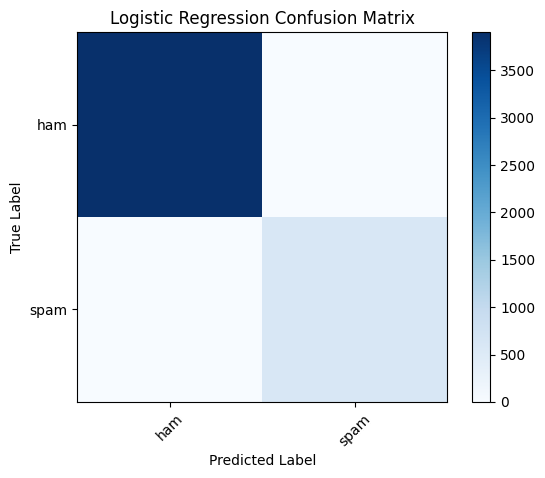

In [ ]:
plt.imshow(lr_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'], rotation=45)
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Tworzenie macierzy pomyłek dla modelu naiwnego klasyfikatora Bayesa

In [ ]:
nb_confusion_matrix = nb_metrics.confusionMatrix().toArray()

## Wyświetlenie macierzy pomyłek modelu naiwnego klasyfikatora Bayesa

In [ ]:
import numpy as np

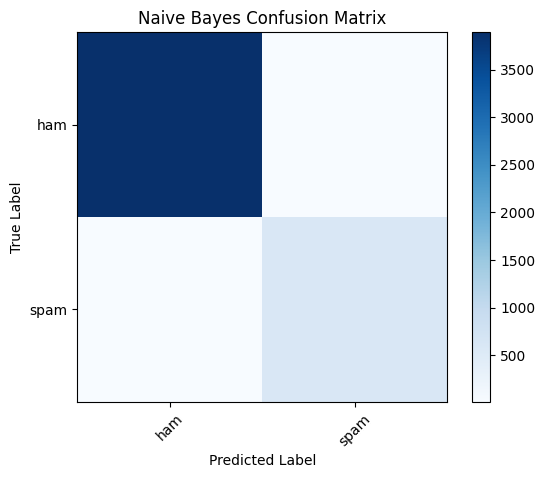

In [ ]:
plt.imshow(nb_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Naive Bayes Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'], rotation=45)
plt.yticks(tick_marks, ['ham', 'spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Ocena wydajności modeli

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
# Predykcje i etykiety dla danych testowych
predictions_and_labels = lr_predictions.select("prediction", "label_index").rdd  # Dla modelu regresji logistycznej
# lub
predictions_and_labels = nb_predictions.select("prediction", "label_index").rdd  # Dla modelu naiwnego klasyfikatora Bayesa

# Tworzenie obiektu MulticlassMetrics
metrics = MulticlassMetrics(predictions_and_labels)

# Obliczanie metryk
accuracy = metrics.accuracy
precision = metrics.precision(label=1.0)  # dla etykiety "spam"
recall = metrics.recall(label=1.0)        # dla etykiety "spam"
f1_score = metrics.fMeasure(label=1.0)    # dla etykiety "spam"

# Wyświetlenie wyników
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

Accuracy: 1.00
Precision: 0.99
Recall: 0.98
F1-score: 0.98


## Funkcja do przetetstowania modelu na podstawie przykładowych zdań

In [ ]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml import PipelineModel

In [ ]:
def predict_spam_or_ham(model, text):
    # Tworzenie DataFrame z wprowadzonym tekstem
    input_text_df = spark.createDataFrame([(text,)], ["text"])

    # Tokenizacja tekstu
    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    input_text_df = tokenizer.transform(input_text_df)

    # Usunięcie stop words
    input_text_df = remover.transform(input_text_df)

    # Przekształcenie słów na wektor cech
    input_text_df = cv_model.transform(input_text_df)

    # Przewidywanie etykiety za pomocą wczytanego modelu
    prediction = model.transform(input_text_df)

    # Wyświetlenie wyniku predykcji
    result = prediction.select("prediction").collect()[0]
    if result.prediction == 1.0:
        print("Wprowadzony tekst jest uznany za SPAM.")
    else:
        print("Wprowadzony tekst jest uznany za nie-SPAM.")

### Przykładowe wywołania funkcji:

In [ ]:
test_text = "500 New Mobiles from 2004, MUST GO! Txt: NOKIA to No: 89545 & collect yours today!From ONLY ÂŁ1 www.4-tc.biz 2optout 087187262701.50gbp/mtmsg18"
predict_spam_or_ham(lr_model, test_text)  # lr_model to wczytany wcześniej model regresji logistycznej

Wprowadzony tekst jest uznany za SPAM.


In [ ]:
test_text = "Congratulations! You've won a $1000 gift card. Click here to claim now."
predict_spam_or_ham(lr_model, test_text)

Wprowadzony tekst jest uznany za SPAM.


In [ ]:
test_text = 'Urgent! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18'
predict_spam_or_ham(lr_model, test_text)

Wprowadzony tekst jest uznany za SPAM.


In [ ]:
test_text = 'How wonderful you are'
predict_spam_or_ham(lr_model, test_text)

Wprowadzony tekst jest uznany za nie-SPAM.
